### ANÁLISIS DE ENSAYO DE LABORATORIO: TRACCIÓN EN VARILLAS CORRUGADAS DE REFUERZO ESTRUCTURAL (ACERO ASTM A706 – NTC 2289)<br>

<b>RESUMEN</b><br>
Se llevó a cabo un ensayo de tracción sobre una varilla #3 (3/8”) de acero de refuerzo para estructuras de concreto armado (varilla corrugada). Los datos de dicho ensayo fueron recolectados mediante los sensores de la máquina y serán analizados en el presente documento, todo ello a la luz de las normatividades aplicables. Con base en los datos obtenidos se estimará el módulo de elasticidad (E), el límite de fluencia (fy), el esfuerzo último (fu), la tenacidad, la resiliencia y la ductilidad.

In [1]:
# Importaciones básicas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Organización de los datos

In [2]:
# Creación del DataFrame (llamado "df")

header =['carga', 'esfuerzo', 'def_unit', 'desplazamiento']
df = pd.read_csv('data.csv', sep=';', decimal=',')
df.columns = header
df.dtypes

carga             float64
esfuerzo          float64
def_unit          float64
desplazamiento    float64
dtype: object

In [3]:
# Cambiar el tipo de dato de "String" a número para operar con ellos
df[header].astype('float64')

# Visualización de parte de los datos
print(df.dtypes)
df.head(5)

carga             float64
esfuerzo          float64
def_unit          float64
desplazamiento    float64
dtype: object


,carga,esfuerzo,def_unit,desplazamiento
0,0.313,4.412,0.000,0.062
1,0.581,8.194,0.012,0.187
2,0.637,8.982,0.044,0.436
3,0.759,10.716,0.081,0.810
4,1.519,21.432,0.106,1.122


In [4]:
# Inspección: No hay datos nulos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carga           173 non-null    float64
 1   esfuerzo        173 non-null    float64
 2   def_unit        173 non-null    float64
 3   desplazamiento  173 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


In [5]:
# ...Comprobación...
df.isnull().describe()

,carga,esfuerzo,def_unit,desplazamiento
count,173,173,173,173
unique,1,1,1,1
top,False,False,False,False
freq,173,173,173,173


In [6]:
# Resumen útil 
df.describe()

,carga,esfuerzo,def_unit,desplazamiento
count,173.000000,173.000000,173.000000,173.000000
mean,38.842896,548.380486,2.061301,20.635601
std,12.907518,181.762459,1.166460,11.654034
min,0.313000,4.412000,0.000000,0.062000
25%,37.290000,526.183000,1.091000,10.970000
50%,45.108000,636.493000,2.038000,20.381000
75%,47.040000,663.756000,3.029000,30.291000
max,47.252000,666.750000,4.456000,44.439000


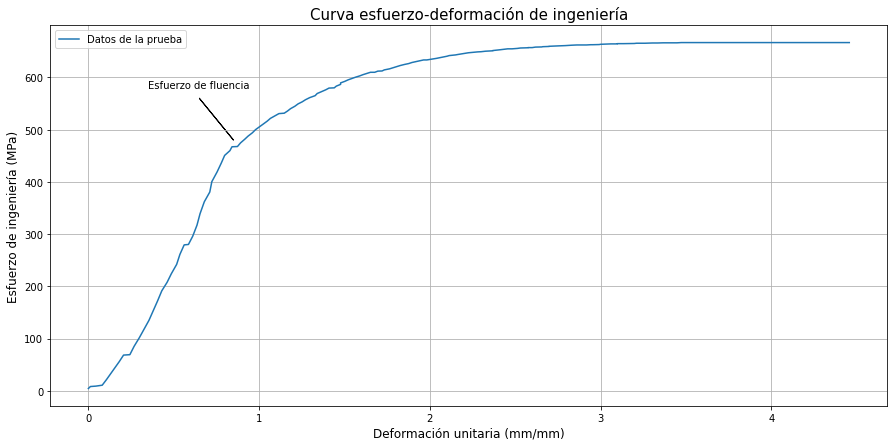

In [7]:
# Exploración inicial de los datos

plt.figure( figsize=(15, 7) )
plt.plot(df.def_unit, df.esfuerzo, label='Datos de la prueba')
plt.arrow(0.85, 480, -0.2, 80)
plt.text(0.35, 580, 'Esfuerzo de fluencia')
plt.grid()
plt.title('Curva esfuerzo-deformación de ingeniería', fontsize=15)
plt.xlabel('Deformación unitaria (mm/mm)', fontsize=12)
plt.ylabel('Esfuerzo de ingeniería (MPa)', fontsize=12)
plt.Circle((0.5, 0.5), 0.3, fill=False)
plt.legend();

A partir de la gráfica se observa que el límite de fluencia está entre 400 MPa y 500 MPa. Para ubicarlo con precisión me aprovecharé del cambio de pendiente que ocurre allí.

In [8]:
# Fitrado de los datos alrededor del punto de fluencia tentativo
df_fluencia = df[(df.esfuerzo < 500) & (df.esfuerzo > 400)]
df_fluencia.describe()

,carga,esfuerzo,def_unit,desplazamiento
count,11.000000,11.000000,11.000000,11.000000
mean,32.416636,458.133818,0.845364,8.476545
std,2.058260,29.192826,0.076985,0.752923
min,28.378000,400.428000,0.723000,7.417000
25%,31.437500,443.607500,0.788500,7.853500
50%,32.588000,467.245000,0.841000,8.539000
75%,33.889500,478.197500,0.903500,9.068500
max,35.000000,493.877000,0.960000,9.598000


In [9]:
# Datos alrededor de la fluencia
df_fluencia

,carga,esfuerzo,def_unit,desplazamiento
27,28.378,400.428,0.723,7.417
28,29.707,419.181,0.754,7.542
29,30.935,436.516,0.779,7.729
30,31.940,450.699,0.798,7.978
31,32.555,459.839,0.829,8.227
32,32.588,467.245,0.841,8.539
33,33.147,467.718,0.873,8.726
34,33.638,474.652,0.891,8.975
35,34.141,481.743,0.916,9.162
36,34.554,487.574,0.935,9.349


In [10]:
# ESFUERZO DE FLUENCIA!!!
diferencias = df_fluencia.esfuerzo - df_fluencia['esfuerzo'].shift(periods=1, fill_value=0)
indice_min = diferencias.idxmin()
esf_fluencia = df.esfuerzo[indice_min-1]

print('Esfuerzo de fluencia: {} MPa'.format(esf_fluencia))
print('<===================================================>')

Esfuerzo de fluencia: 467.245 MPa
<===================================================>


In [11]:
# Hallar el rango elástico de los datos
elasticidad = df[df['esfuerzo'] <= esf_fluencia]   # Filtro del rango elástico
lim_elas = elasticidad['esfuerzo'].max()   # Esfuerso de fluencia
e_y = elasticidad['def_unit'][elasticidad['esfuerzo'].idxmax()]   # Deformación unitaria en la fluencia
print('Límite elástico: {} MPa\nDeformación unitaria en la fluencia: {} mm/mm'.format(lim_elas, e_y))
print('<===================================================>')

Límite elástico: 467.245 MPa
Deformación unitaria en la fluencia: 0.841 mm/mm
<===================================================>


La norma establece que el esfuerzo de fluencia mínimo debe ser 420 MPa, y el máximo debe ser 540 MPa. En consecuencia, la
varilla ensayada cumple con la norma.

In [12]:
# Análisis del estado de falla
Fu = df['esfuerzo'].max()   # Esfuerzo de ruptura (Fu) de la probeta
e_u = df['def_unit'][df['esfuerzo'].idxmax()]   # Deformación unitaria en la falla
print('Límite de falla: {} MPa\nDeformación unitaria en la falla: {} mm/mm'.format(Fu, e_u))
print('<===================================================>')

Límite de falla: 666.75 MPa
Deformación unitaria en la falla: 3.472 mm/mm
<===================================================>


Según la norma, la resistencia a la tracción debe ser, por lo menos, 1.25 veces el valor del esfuerzo de fluencia. Entonces
1.25(467.25) MPa = 584.06 MPa. Vemos entonces que la varilla ensayada tiene una resistecia mayor que la mínima exigida por la norma.

### Aproximaciones del Módulo de elasticidad E (Módulo de Young)
El módulo de elasticidad es la pendiente de la gráfica esfuerzo-deformación en el rango elástico (el cual es, teóricamente, un segmento de recta).

Dada la inspección inicial de los datos (mirar la grafica primera) calcularé tres aproximaciones al módulo de elasticidad. La primera será, simplemente, un promedio de las pendientes entre el origen (0, 0) y cada uno de los puntos del rango elástico.

Para la segunda y tercera estimación de E usaré un enfoque de <b>Machine Learning</b>. Haré dos regresiones lineales con los datos del rango elástico, la primera de las cuales es libre de estimar el intercepto, mientras que la segunda será forzada a que el intercepto sea (0, 0) como teóricamente debería ser.

In [13]:
# Aproximación de E como la media de la pendiente de cada punto
E_1 = (elasticidad.esfuerzo[1:]/elasticidad.def_unit[1:]).mean()
print('Módulo de elasticidad: {} MPa'.format( round( E_1 ) ))
print('<===================================================>')

Módulo de elasticidad: 433 MPa
<===================================================>


In [14]:
'''Aproximación de E como la pendiente de la regreción lineal de los datos en el rango elástico suponiendo
   que el intercepto NO ES el origen. Este modelo SÓLO es útil para aproximar la pendiente, pero no es útil
   para predecir valores en el rango elástico'''

elast_aprox_1 = LinearRegression(fit_intercept=True)   # Modelo: Instancia de la clase "LinearRegression"
elast_aprox_1.fit(np.array(elasticidad.def_unit)[:, None], np.array(elasticidad.esfuerzo)[:, None])   # Entrenar el modelo
esfu_elas_1 = elast_aprox_1.predict(np.array(elasticidad.def_unit)[:, None])   # Usar el modelo para predecir

print('Módulo de elasticidad: {} MPa'.format( round( elast_aprox_1.coef_[0, 0] ) ))
print('<===================================================>')

Módulo de elasticidad: 590 MPa
<===================================================>


In [15]:
'''Aproximación de E como la pendiente de la regreción lineal de los datos en el rango elástico suponiendo
   que el intercepto SÍ ES el origen'''

elast_aprox_2 = LinearRegression(fit_intercept=False)   # Modelo: Instancia de la clase "LinearRegression"
elast_aprox_2.fit(np.array(elasticidad.def_unit)[:, None], np.array(elasticidad.esfuerzo)[:, None])   # Entrenar el modelo
esfu_elas_2 = elast_aprox_2.predict(np.array(elasticidad.def_unit)[:, None])   # Usar el modelo para predecir

print('Módulo de elasticidad: {} MPa'.format( round( elast_aprox_2.coef_[0, 0] ) ))
print('<===================================================>')

Módulo de elasticidad: 509 MPa
<===================================================>


<b>Conclusión</b>

Los valores obtenidos del módulo de elasticidad mediante las aproximaciones arriba descritas para el material de la varilla discrepan notoriamente con el valor de referencia de la literatura (200000 MPa). La explicaión más probable para esta discrepancia tan grande en el módulo de elasticidad (pero no así en los esfuerzos de fluencia y falla) es un posible mal ajuste
de las mordazas de la máquina universal, lo cual habría permitido un deslizamiento ligero de la probeta de pruebas. Dadas las deformaciones relativamente pequeñas de los materiales metálicos, un deslizamiento de solo 5 mm en la prueba de tracción haría
que el valor obtenido del módulo de elasticidad difiera enormemente del valor real.

### ...Visualización de los resultados...

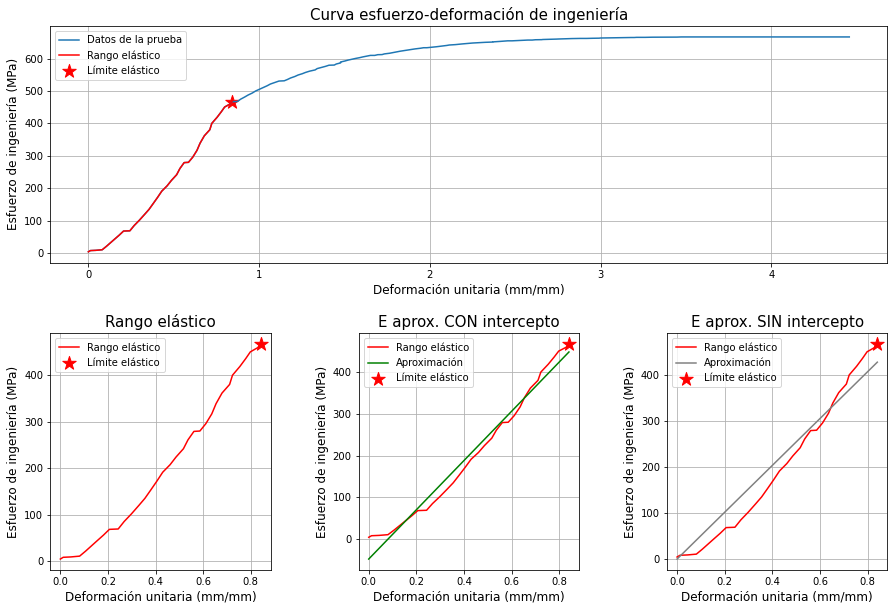

In [16]:
# Espacio de ploteo
fig = plt.figure(figsize=(15, 10))
# Grid para ubicar cada gráfica
grid = plt.GridSpec(2, 3, hspace=0.3, wspace=0.4)

# Gráfica de los datos de la prueba (Gráfica superior) **********************************
# ***************************************************************************************
datos = fig.add_subplot(grid[0, :])
rng_elas = fig.add_subplot(grid[1, 0])
elast_reg_1 = fig.add_subplot(grid[1, 1])
elast_reg_2 = fig.add_subplot(grid[1, 2])

datos.plot(df.def_unit, df.esfuerzo, label='Datos de la prueba')
datos.plot(elasticidad.def_unit, elasticidad.esfuerzo, color='red', label='Rango elástico')
datos.scatter(
    elasticidad['def_unit'].max(), elasticidad['esfuerzo'].max(),
    s=200, color='red', marker='*',
    label='Límite elástico'
)
datos.grid()
datos.set_title('Curva esfuerzo-deformación de ingeniería', fontsize=15)
datos.set_xlabel('Deformación unitaria (mm/mm)', fontsize=12)
datos.set_ylabel('Esfuerzo de ingeniería (MPa)', fontsize=12)
datos.legend()
# ***************************************************************************************


# Gráfica del rango elástico (Gráfica inferior izquierda) *******************************
# ***************************************************************************************
rng_elas.plot(elasticidad.def_unit, elasticidad.esfuerzo, color='red', label='Rango elástico')
rng_elas.scatter(
    elasticidad['def_unit'].max(), elasticidad['esfuerzo'].max(),
    s=200, color='red', marker='*',
    label='Límite elástico'
)
rng_elas.set_title('Rango elástico', fontsize=15)
rng_elas.set_xlabel('Deformación unitaria (mm/mm)', fontsize=12)
rng_elas.set_ylabel('Esfuerzo de ingeniería (MPa)', fontsize=12)
rng_elas.grid()
rng_elas.legend()
# ***************************************************************************************


# Gráfica del rango elástico y E aprox. 1 (Gráfica inferior izquierda) ******************
# ***************************************************************************************
elast_reg_1.plot(elasticidad.def_unit, elasticidad.esfuerzo, color='red', label='Rango elástico')
elast_reg_1.plot(elasticidad.def_unit, esfu_elas_1, label='Aproximación', color='green')
elast_reg_1.scatter(
    elasticidad['def_unit'].max(), elasticidad['esfuerzo'].max(),
    s=200, color='red', marker='*',
    label='Límite elástico'
)
elast_reg_1.set_title('E aprox. CON intercepto', fontsize=15)
elast_reg_1.set_xlabel('Deformación unitaria (mm/mm)', fontsize=12)
elast_reg_1.set_ylabel('Esfuerzo de ingeniería (MPa)', fontsize=12)
elast_reg_1.grid()
elast_reg_1.legend()
# ***************************************************************************************


# Gráfica del rango elástico y E aprox. 2 (Gráfica inferior izquierda) ******************
# ***************************************************************************************
elast_reg_2.plot(elasticidad.def_unit, elasticidad.esfuerzo, color='red', label='Rango elástico')
elast_reg_2.plot(elasticidad.def_unit, esfu_elas_2, label='Aproximación', color='gray')
elast_reg_2.scatter(
    elasticidad['def_unit'].max(), elasticidad['esfuerzo'].max(),
    s=200, color='red', marker='*',
    label='Límite elástico'
)
elast_reg_2.set_title('E aprox. SIN intercepto', fontsize=15)
elast_reg_2.set_xlabel('Deformación unitaria (mm/mm)', fontsize=12)
elast_reg_2.set_ylabel('Esfuerzo de ingeniería (MPa)', fontsize=12)
elast_reg_2.grid()
elast_reg_2.legend()
# ***************************************************************************************

plt.show();

## Cálculos de áreas bajo la curva para determinar la resiliencia, la tenacidad y la ductilidad

La siguiente función calcula la integral, dada una nube de puntos

In [17]:
def integral(X, Y):
    X, Y = list(X), list(Y)
    longitud = max(X) - min(X)
    delta_X = longitud/len(X)
    
    integral = 0
    for i in range(len(X)):
        integral += delta_X*Y[i]
    
    return integral

In [18]:
# Tenacidad: área bajo la curva hasta la falla (toda la curva)
tenacidad = integral(df.def_unit, df.esfuerzo)
print('Tenacidad: {} MJ/m^3'.format( round( tenacidad, 2 ) ))
print('<===================================================>')

Tenacidad: 2443.58 MJ/m^3
<===================================================>


In [19]:
# Resiliencia: área bajo la curva en el rango elástico
resiliencia = integral(elasticidad.def_unit, elasticidad.esfuerzo)
print('Resiliencia: {} MJ/m^3'.format( round( resiliencia, 2 ) ))
print('<===================================================>')

Resiliencia: 180.21 MJ/m^3
<===================================================>


In [20]:
# Ductilidad: área bajo la curva en la zona plástica
ductilidad = tenacidad - resiliencia
print('Ductilidad: {} MJ/m^3'.format( round( ductilidad, 2 ) ))
print('<===================================================>')

Ductilidad: 2263.37 MJ/m^3
<===================================================>
